In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

In [2]:
#data = {"32.058895,34.805781":[{"geometry":{"location":{"lat":32.0852999,"lng":34.78176759999999},"viewport":{"northeast":{"lat":32.146611,"lng":34.8519761},"southwest":{"lat":32.029252,"lng":34.7425159}}},"icon":"https://maps.gstatic.com/mapfiles/place_api/icons/geocode-71.png","name":"Tel Aviv-Yafo","photos":[{"height":1648,"html_attributions":["<a href=\"https://maps.google.com/maps/contrib/110771339807222144934\">Sticky sweet girl</a>"],"photo_reference":"CkQ0AAAAdapTCVcGxSXELYf0ItQjeYz2YYXsf8bPDIAME6QlXB24NN5XeFtYpYVUfWv4xS-y3OaF-dwuxb6H5D7c3AwIExIQ_okaFGhE4OI5HyM9vtMUQxoUx1LzhMW4_jGt0o_AsWGblRMpl9Y","width":2133}],"place_id":"ChIJH3w7GaZMHRURkD-WwKJy-8E","reference":"ChIJH3w7GaZMHRURkD-WwKJy-8E","scope":"GOOGLE","types":["locality","political"],"vicinity":"Tel Aviv-Yafo"},{"business_status":"OPERATIONAL","geometry":{"location":{"lat":32.0589857,"lng":34.8056766},"viewport":{"northeast":{"lat":32.0603346802915,"lng":34.8070255802915},"southwest":{"lat":32.0576367197085,"lng":34.8043276197085}}},"icon":"https://maps.gstatic.com/mapfiles/place_api/icons/generic_recreational-71.png","name":"Edith Wolfson Park","opening_hours":{"open_now":"true"},"photos":[{"height":2448,"html_attributions":["<a href=\"https://maps.google.com/maps/contrib/116110174678870103507\">Moran Ben Hur</a>"],"photo_reference":"CkQ0AAAAMK1bPevpqhgWKLsolhsC4PLRE3l-SyIMRucrLL6kDWIeC5OQ5tX2dlKABkvM6mujuD_ogtw3KeZfCNzTBcjYOxIQpBqEmFr-sV18D6LdnGuIsxoUWluDF2-e5WeQChXLY15aiPLPWdA","width":3264}],"place_id":"ChIJJ0kXzAhLHRURp3kHR9URrg4","plus_code":{"compound_code":"3R54+H7 Tel Aviv-Yafo, Israel","global_code":"8G4P3R54+H7"},"rating":4.4,"reference":"ChIJJ0kXzAhLHRURp3kHR9URrg4","scope":"GOOGLE","types":["park","tourist_attraction","point_of_interest","establishment"],"user_ratings_total":2839,"vicinity":"Tel Aviv-Yafo"}]}

Please enter coordinate list and radius in following format:
 - Coordinate list - lat,lon/lat,lon...
 - Radius = Positive number

In [141]:
print("Coordinate list - ")
coordinate_list = input()
print("Radius - ")
radius = input()
params = {"coordinate_list":coordinate_list,"radius":radius}

Coordinate list - 
32.058895,34.805781/32.058895,34.805782
Radius - 
150


In [142]:
data = requests.get("http://192.168.1.23:5000/api/circlesearcher",params)

In [143]:
data = data.json()
print(data)

{'32.058895,34.805781': [{'geometry': {'location': {'lat': 32.0852999, 'lng': 34.78176759999999}, 'viewport': {'northeast': {'lat': 32.146611, 'lng': 34.8519761}, 'southwest': {'lat': 32.029252, 'lng': 34.7425159}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/geocode-71.png', 'name': 'Tel Aviv-Yafo', 'photos': [{'height': 3048, 'html_attributions': ['<a href="https://maps.google.com/maps/contrib/116127180746491988473">ITAY ROITMAN AERIAL PRODUCTION</a>'], 'photo_reference': 'CkQ0AAAAEkZ6GAI-mYra2ILGdlab1dmLJGXUi6DZHiODSV3BQFeZnCIWxpz8nyICRPalcn63xfqz9UeUJzqvO5e-pH790RIQ-2gjaIR4gA-RFFs9CeeitBoUA0EbHma8VB8dyI2ryk4sAdr8X-o', 'width': 5418}], 'place_id': 'ChIJH3w7GaZMHRURkD-WwKJy-8E', 'reference': 'ChIJH3w7GaZMHRURkD-WwKJy-8E', 'scope': 'GOOGLE', 'types': ['locality', 'political'], 'vicinity': 'Tel Aviv-Yafo'}, {'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 32.0589857, 'lng': 34.8056766}, 'viewport': {'northeast': {'lat': 32.0603346802915, 'lng': 34.807

# Calculates how many of each type are in the coordinate and returns a df with the ammount of each type

In [269]:
def calculate_type_ammounts(current_coordinate):
    types_dictionary = {}
    for types in current_coordinate["types"]:
        for current_type in types:
            if current_type in types_dictionary:
                types_dictionary[current_type][0] += 1
            else:
                types_dictionary[current_type] = [1]
    types_df = pd.DataFrame.from_dict(types_dictionary,orient ='index',columns = ["Ammount"])
    types_df = types_df.sort_values(by="Ammount",ascending = False)
    return types_df

# Sets requested types in the coordinate dict
 - Orders the dict in the following way:
   - data_frame_dict[current_coordinate][type_name]:[data_frame] - Contains only location of requested type
   - Sorted by rating

In [305]:
def make_types_dictionary(data_frame_dict):
    print("Please enter desired types to check")
    my_types = input()
    my_types = my_types.split(',')
    
    #Remove duplicate types to decrese runtime
    my_types = list(dict.fromkeys(my_types))
    for coordinate in data_frame_dict:
        data_frame_dict[coordinate]["my_types"] = {}
        my_coordinate = data_frame_dict[coordinate]["locations"]
        for current_type in my_types:
            current_type_df = my_coordinate[my_coordinate["types"].apply(lambda location: current_type in location)]
            current_type_df.sort_values(by = "rating", ascending = False)
            #print(data_frame_dict[coordinate]["locations"])
            data_frame_dict[coordinate]["my_types"][current_type] = current_type_df 
    return data_frame_dict

# 

In [270]:
def take_care_of_data(data_frame_dict):
    data_frame_dict = make_types_dictionary(data_frame_dict)
    for coordinate in data_frame_dict:
        types_df = calculate_type_ammounts(data_frame_dict[coordinate]["locations"])
        data_frame_dict[coordinate]["ammount_of_each_type"] = types_df
    master_df = pd.DataFrame.from_dict(data_frame_dict)
    return master_df

# Cell that makes a data frame with all the coordinates data frames inside in the following format
 - Select types to specifecly check in a list (type1,type2...)
 - master_df = {coordinate: {locations: location_list_df, ammount_of_each_type: df({type:ammount...}),{types:{type1:df_of_type1...}}),
                coordinate2: ...}

In [317]:
data_frame_dict = {}
for coordinate in data:
    my_data = data[coordinate]
    name_list = []
    for location in my_data:
        name_list.append(location["name"])
        if not "rating" in location:
            location["rating"] = 0
            location["user_ratings_total"] = 0
    my_coordinate = pd.DataFrame(data[coordinate])
    #my_coordinate.index = name_list
    data_frame_dict[coordinate] = {"locations" : my_coordinate}
master_df = take_care_of_data(data_frame_dict)
master_df

Please enter desired types to check
park,point_of_interest


,"32.058895,34.805781","32.058895,34.805782"
locations,ge...,ge...
my_types,"{'park': ['geometry', 'icon'], 'point_of_inter...","{'park': ['geometry', 'icon'], 'point_of_inter..."
ammount_of_each_type,Ammount point_of_interest ...,Ammount point_of_interest ...


In [236]:
def get_axes(axes_list ,row, column):
    current_axes = axes_list[row][column]
    return current_axes

## Function for plotting all coordinate data
 - Plot1: ammount_of_each_type:
   - Plots a bar graph of ammounts by type
     - only plots top 10 types for space

Index(['locations', 'my_types', 'ammount_of_each_type'], dtype='object')
Index(['locations', 'my_types', 'ammount_of_each_type'], dtype='object')


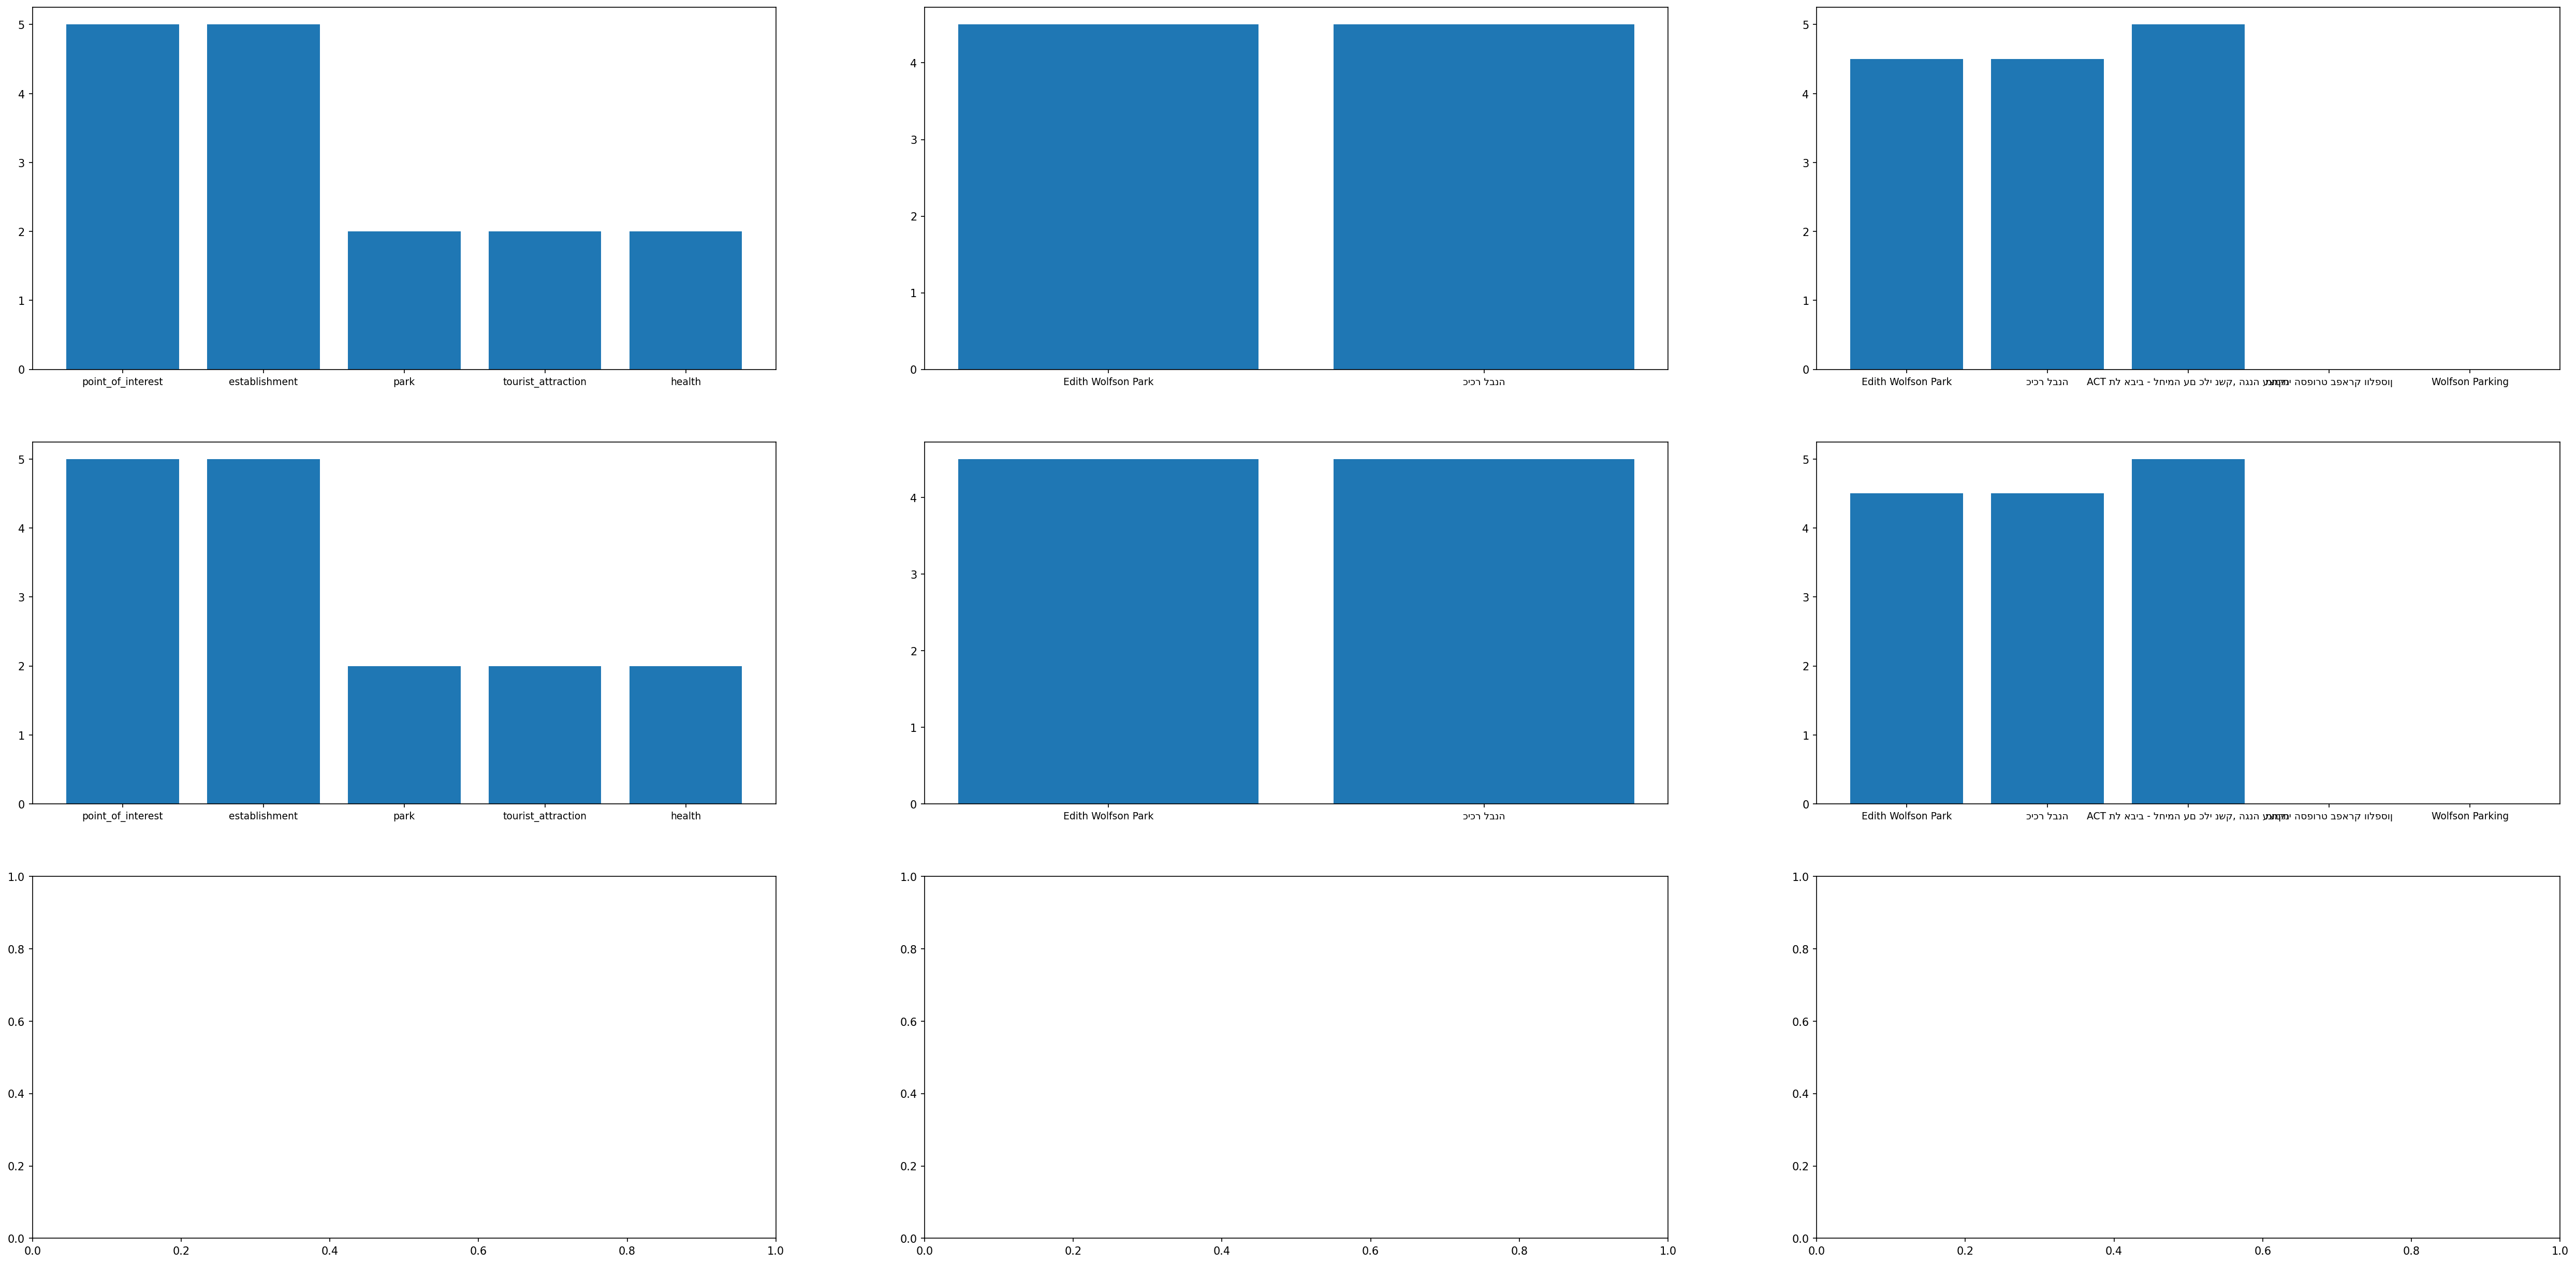

In [368]:
def plot_data(master_df):
    
    #Calculates by ammount of rows in each coordinate - 1: 1 axes for ammount_of_types plus one axes for each type
    
    desired_column_ammount = len(master_df.loc["my_types"][0]) + 1
    
    #Calculates desired row ammount: 1 for each coordinate plus 1 master
    
    desired_row_ammount = len(master_df.columns) + 1
    
    #Calculate figure size - multiply desired axes size (14*8) by the ammount of rows and columns    

    figure_length = 14 * desired_column_ammount
    figure_height = 7 * desired_row_ammount
    data_figure, axes_list = plt.subplots(figsize=(figure_length,figure_height),dpi= 150,nrows = desired_row_ammount,
                               ncols=desired_column_ammount)
    current_row = 0
    for coordinate in master_df:
        coordinate_dict = master_df[coordinate]
        plot_coordinate(coordinate_dict, current_row, axes_list)
        current_row = current_row + 1
plot_data(master_df)

In [367]:
def plot_coordinate(coordinate_dict, current_row, axes_list):
    current_coordinate = str(coordinate_dict.keys())
    print(current_coordinate)
    current_column = 0
    current_ax = get_axes(axes_list, current_row, current_column)
    current_ax = plot_types_ammount(coordinate_dict["ammount_of_each_type"],current_ax)
    current_column = 1
    for current_type in coordinate_dict["my_types"]:
        current_ax = get_axes(axes_list, current_row, current_column)
        #current_ax.set_title = %s - %s - "Highest rated"%(current_coordinate, current_type) 
        current_ax = plot_type_by_rating(coordinate_dict["my_types"][current_type],current_ax)
        current_column += 1

In [330]:
def plot_types_ammount(types_df,current_ax):
    types_df = types_df.head(5)
    types_list = types_df.index
    ammounts = types_df["Ammount"]
    current_ax.bar(types_list,ammounts)
    current_ax.tick_params(axis="x",labelsize = 9)

In [352]:
def plot_type_by_rating(type_df, current_ax):
    type_df = type_df.head(5)
    name_list = type_df["name"]
    ratings_list = type_df["rating"]
    current_ax.bar(name_list, ratings_list)
    current_ax.tick_params(axis="x",labelsize = 9)

In [221]:
my_dict = {}
data_frame_dict[coordinate][current_type]= my_coordinate[my_coordinate["types"].apply(lambda location: any(current_type in location for current_type in my_types))]